In [157]:
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline, utils

In [158]:
def derivative_spectrum(y_data):
    """ 
    Calculates the Numerical Derivative using the gradient
    """
    return np.gradient(y_data)

def find_zero_crossing_lin_int(x_data, y_prime, tol = 1e-5):
    """ 
    Finds zero crossing in the given derivative spectrum

    For this we use a linear interpolation approach (i.e sign change yi yi-1 <0)
    """

    zero_crossings = []
    zero_crossings_indices = []
    for i in range(1,len(y_prime)):
        if y_prime[i-1] * y_prime[i] < 0:
            zero_crossing = x_data[i-1] - y_prime[i-1] * (x_data[i] - x_data[i-1])/ (y_prime[i] - y_prime[i-1])
            zero_crossings.append(zero_crossing)
            zero_crossings_indices.append(i)
    return zero_crossings, zero_crossings_indices




def optimize_and_plot(x, y_prime, zero_crossings_indices, idx_zero_crossing, initial_bound, user_bound, bound_type='right', step_size=1):
    """ 
    Performs an optimization of a given area around a zero crossing in the derivative spectrum.

    Attr:
        x: x data points
        y_prime: numerical derivative of the data
        zero_crossing_indices: a list of possible zero crossings in the derivative spectrum
        idx_zero_crossing: the index of the zero crossing we want to look at
        initial_bound: the initial guess for the bound which we want to optimize
        user_bound: a user-defined bound (upper or lower depending on bound_type)
        bound_type: 'right' to optimize the right bound, 'left' to optimize the left bound
        step_size: the step size for the optimization (check with real spectrum)
    """
    def area_difference(left_bound, right_bound, x, y_prime, zero_crossing):
        left_area = np.trapz(y_prime[left_bound:zero_crossing], x[left_bound:zero_crossing])
        right_area = np.trapz(y_prime[zero_crossing:right_bound], x[zero_crossing:right_bound])
        return np.abs(left_area) - np.abs(right_area)

    zero_crossing = zero_crossings_indices[idx_zero_crossing]

    if bound_type == 'right':
        left_bound = initial_bound
        best_bound = initial_bound
        best_area_diff = area_difference(left_bound, initial_bound, x, y_prime, zero_crossing)

        for bound in range(initial_bound, user_bound, step_size):
            current_area_diff = area_difference(left_bound, bound, x, y_prime, zero_crossing)
            if np.abs(current_area_diff) < np.abs(best_area_diff):
                best_area_diff = current_area_diff
                best_bound = bound

        right_bound = best_bound
        left_bound = initial_bound

    elif bound_type == 'left':
        right_bound = initial_bound
        best_bound = initial_bound
        best_area_diff = area_difference(initial_bound, right_bound, x, y_prime, zero_crossing)

        for bound in range(initial_bound, user_bound, -step_size):
            current_area_diff = area_difference(bound, right_bound, x, y_prime, zero_crossing)
            if np.abs(current_area_diff) < np.abs(best_area_diff):
                best_area_diff = current_area_diff
                best_bound = bound

        left_bound = best_bound
        right_bound = initial_bound

    else:
        raise ValueError("Invalid bound_type. Use 'right' or 'left'.")

    # Plotting the derivative spectrum and marking the zero crossings
    plt.plot(x, y_prime, label="Derivative Spectrum")
    plt.scatter(x[zero_crossing], y_prime[zero_crossing], color="red", label="Zero Crossing")

    # Marking the areas with fill_between
    plt.fill_between(x[left_bound:zero_crossing], y_prime[left_bound:zero_crossing], color='blue', alpha=0.3, label='Left Area')
    plt.fill_between(x[zero_crossing:right_bound], y_prime[zero_crossing:right_bound], color='green', alpha=0.3, label='Right Area')

    plt.legend()
    plt.show()

    return left_bound, right_bound

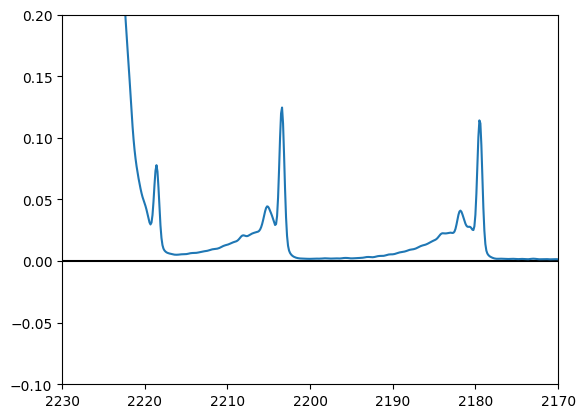

In [203]:
import numpy as np
import pandas as pd


file_path = "shee2.csv"

data = pd.read_csv(file_path, header=None, sep=";")
data = data.replace(',', '.', regex=True).astype(float)
data_np = data.to_numpy()

x = data_np[:,0]

y = data_np[:,1]
plt.gca().invert_xaxis()
plt.hlines(0, 2230, 2170, color='black')
plt.xlim(2230,2170)
plt.ylim(-0.1,0.2)
plt.plot(x,y)
plt.show()

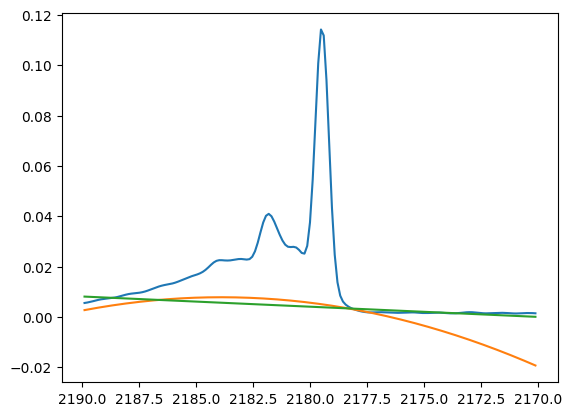

In [196]:
x_peaks = x[np.where(x > 2170)]
x_peaks = x_peaks[np.where(x_peaks < 2190)]
# find the indices of original data
indices = np.where(np.isin(x, x_peaks))
y_peak = y[indices]


baseline_fitter = Baseline(x_peaks)

bk_1, params_1 = baseline_fitter.modpoly(y_peak, poly_order=2)
bk_2, params_2 = baseline_fitter.asls(y_peak, lam=1e10, p=0.02)



plt.plot(x_peaks, y_peak)
plt.plot(x_peaks, bk_1)
plt.plot(x_peaks, bk_2)
plt.gca().invert_xaxis()
plt.show()

-0.12059999999974025


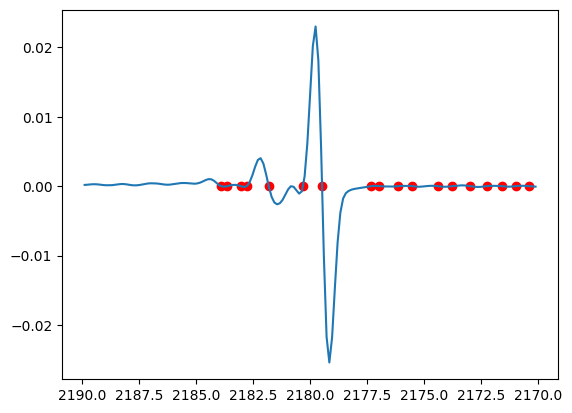

In [197]:
y_prime_peak = derivative_spectrum(y_peak)
zero_crossings, zero_crossings_indices = find_zero_crossing_lin_int(x_peaks, y_prime_peak)

plt.plot(x_peaks, y_prime_peak)
plt.scatter(zero_crossings, np.zeros(len(zero_crossings)), color="red")
plt.gca().invert_xaxis()

step_size = x_peaks[1] - x_peaks[0]
print(step_size)


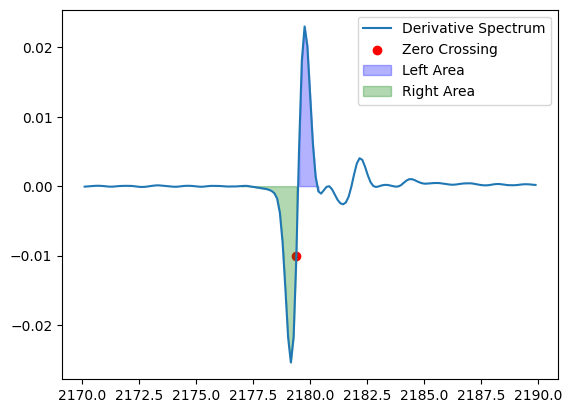

79 108
(165,)


In [ ]:

right_bound, left_bound = optimize_and_plot(x_peaks, y_prime_peak, zero_crossings_indices, 6, zero_crossings_indices[8], zero_crossings_indices[4], bound_type='left', step_size=1)
print(right_bound, left_bound)
print(x_peaks.shape)



-0.10313906599999652


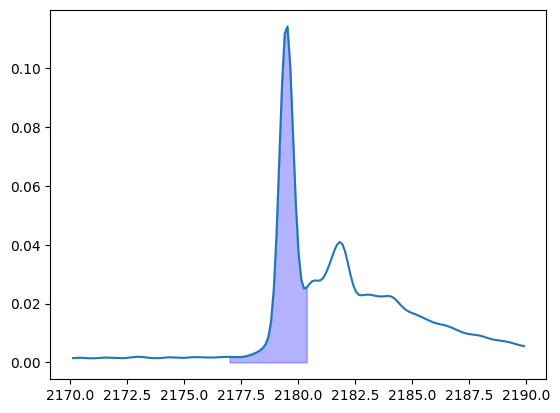

In [199]:
area = np.trapz(y_peak[right_bound:left_bound], x_peaks[right_bound:left_bound])
print(area)
plt.plot(x_peaks, y_peak)
plt.fill_between(x_peaks[right_bound:left_bound], y_peak[right_bound:left_bound], color='blue', alpha=0.3)

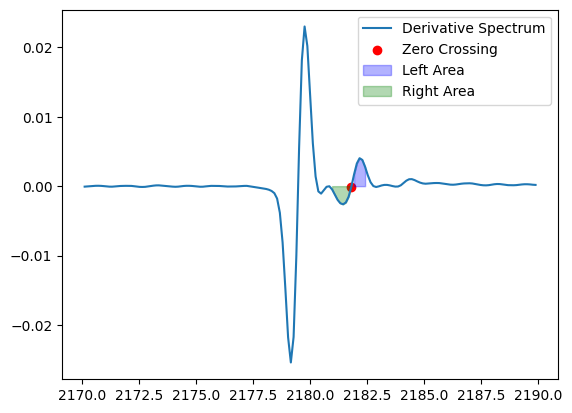

In [200]:
right_bound2, left_bound2 = optimize_and_plot(x_peaks, y_prime_peak, zero_crossings_indices, 4, zero_crossings_indices[5] - 5, zero_crossings_indices[3], bound_type='left', step_size=1)

-0.04990292600000477
Area_ratio: 2.0667939591355156


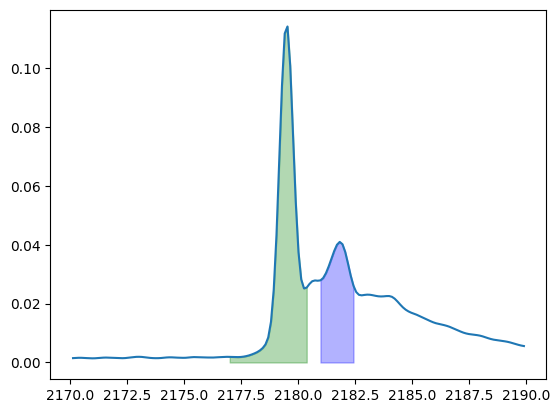

In [201]:
area_2 = np.trapz(y_peak[right_bound2:left_bound2], x_peaks[right_bound2:left_bound2])
print(area_2)
plt.plot(x_peaks, y_peak)
plt.fill_between(x_peaks[right_bound2:left_bound2], y_peak[right_bound2:left_bound2], color='blue', alpha=0.3)
plt.fill_between(x_peaks[right_bound:left_bound], y_peak[right_bound:left_bound], color='green', alpha=0.3)

print("Area_ratio: " + str(area/area_2))